## 4_model_explainability

A notebok to go through shapash

In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
dfp_train = pd.read_csv('./data/rtu/model_train_data.csv')
dfp_train['date'] = pd.to_datetime(dfp_train['date'])

dfp_test = pd.read_csv('./data/rtu/model_test_data.csv')
dfp_test['date'] = pd.to_datetime(dfp_test['date'])

dfp_2020 = pd.read_csv('./data/rtu/2020_data.csv')
dfp_2020['date'] = pd.to_datetime(dfp_2020['date'])

In [14]:
# dict_features = {
#     'weekday' : 'Day of the week encoded (datetime weekday)',
#     'month' : 'Month',
#     'week_number' : 'Week number of the year',
#     'weighted_t2m' : 'Weighted temperature based on main city and population',
#     'weighted_t2m_min' : 'Weighted minimal temperature based on main city and population', 
#     'weighted_t2m_max' : 'Weighted maximal temperature based on main city and population', 
#     'weighted_prectot' : 'Weighted precipitation based on main city and population', 
# }

# columns_features = ['weekday', 'month', 'week_number']
# columns_features = ['weekday', 'month', 'week_number'] + ['weighted_t2m', 'weighted_t2m_min', 'weighted_t2m_max','weighted_prectot']

columns_weather = [ 't2m_min_bordeaux',
       't2m_bordeaux', 't2m_max_bordeaux', 'prectot_bordeaux', 't2m_min_lille',
       't2m_lille', 't2m_max_lille', 'prectot_lille', 't2m_min_paris',
       't2m_paris', 't2m_max_paris', 'prectot_paris', 't2m_min_rennes',
       't2m_rennes', 't2m_max_rennes', 'prectot_rennes', 't2m_min_nantes',
       't2m_nantes', 't2m_max_nantes', 'prectot_nantes', 't2m_min_toulouse',
       't2m_toulouse', 't2m_max_toulouse', 'prectot_toulouse',
       't2m_min_marseille', 't2m_marseille', 't2m_max_marseille',
       'prectot_marseille', 't2m_min_lyon', 't2m_lyon', 't2m_max_lyon',
       'prectot_lyon', 't2m_min_nice', 't2m_nice', 't2m_max_nice',
       'prectot_nice', 't2m_min_strasbourg', 't2m_strasbourg',
       't2m_max_strasbourg', 'prectot_strasbourg', 't2m_min_montpellier',
       't2m_montpellier', 't2m_max_montpellier', 'prectot_montpellier',
       'weighted_t2m', 'weighted_t2m_min', 'weighted_t2m_max',
       'weighted_prectot']

columns_features = ['weekday', 'month', 'week_number'] + columns_weather

dict_features = {feature : feature for feature in columns_features}

In [15]:
# Keep it simple only date and consumption
column_target = 'daily_electrical_consumption'
X_train, y_train = dfp_train[columns_features], dfp_train[column_target]
X_test, y_test = dfp_test[columns_features], dfp_test[column_target]

X_2020 = dfp_2020[columns_features]

In [16]:
# Build a model with random (used the best configuratioh from hyperopt)
model = RandomForestRegressor(**{'criterion': 'mse', 'max_depth': 47, 'max_features': 'auto', 'min_samples_split': 0.1, 'n_estimators': 20, 'random_state' : 0})
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
rmse

444796.5332657018

In [17]:
y_pred = pd.DataFrame(model.predict(X_test),columns=['pred'],index=X_test.index)

In [18]:
from shapash.explainer.smart_explainer import SmartExplainer
xpl = SmartExplainer(features_dict=dict_features) # Optional parameter, dict specifies label for features name

In [19]:
xpl.compile(
    x=X_test,
    model=model,
    y_pred=y_pred # Optional
)

Backend: Shap TreeExplainer


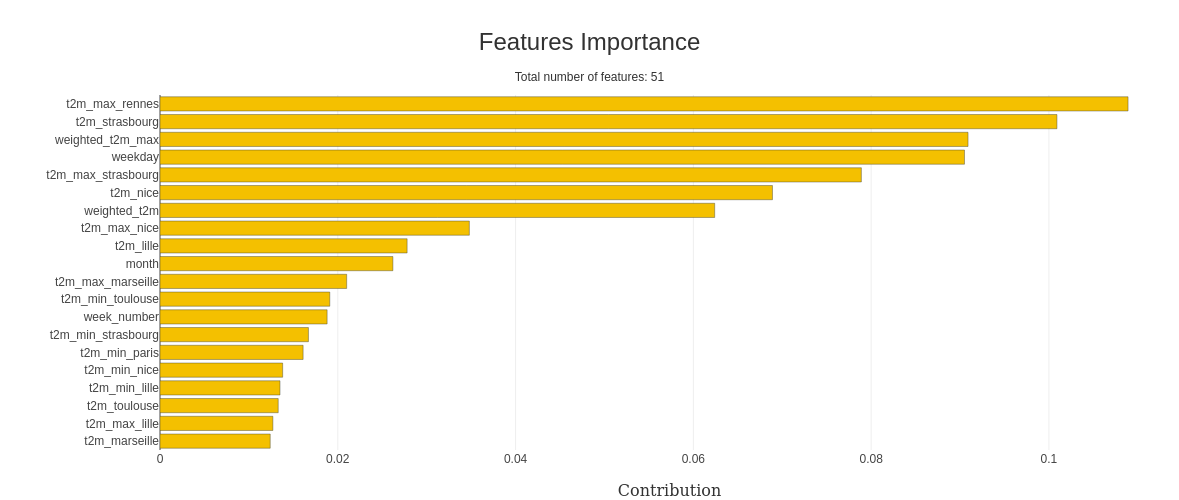

In [20]:
xpl.plot.features_importance()

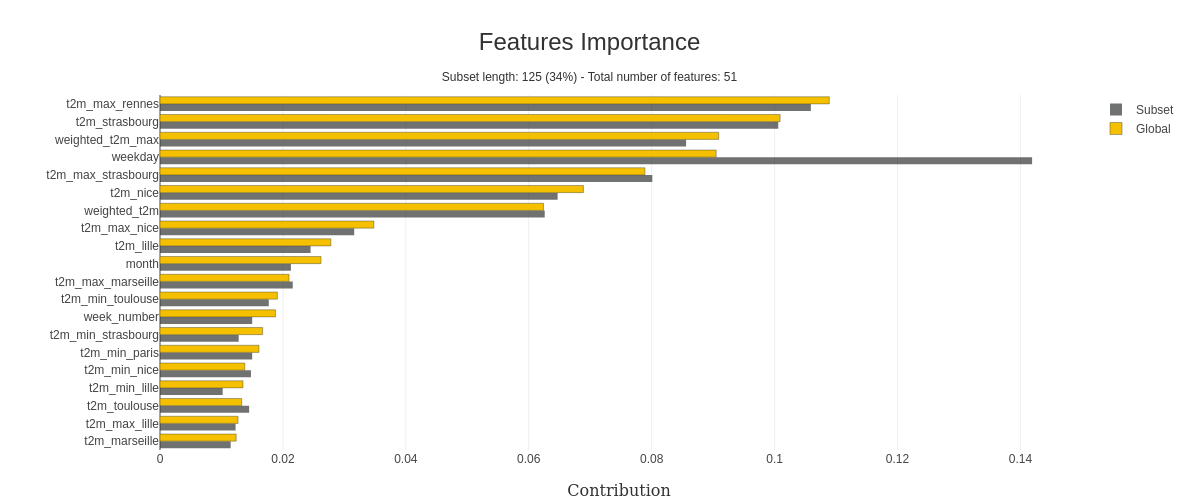

In [31]:
subset = X_test[X_test['weekday'].isin([5,6])].index.tolist()
xpl.plot.features_importance(selection=subset)

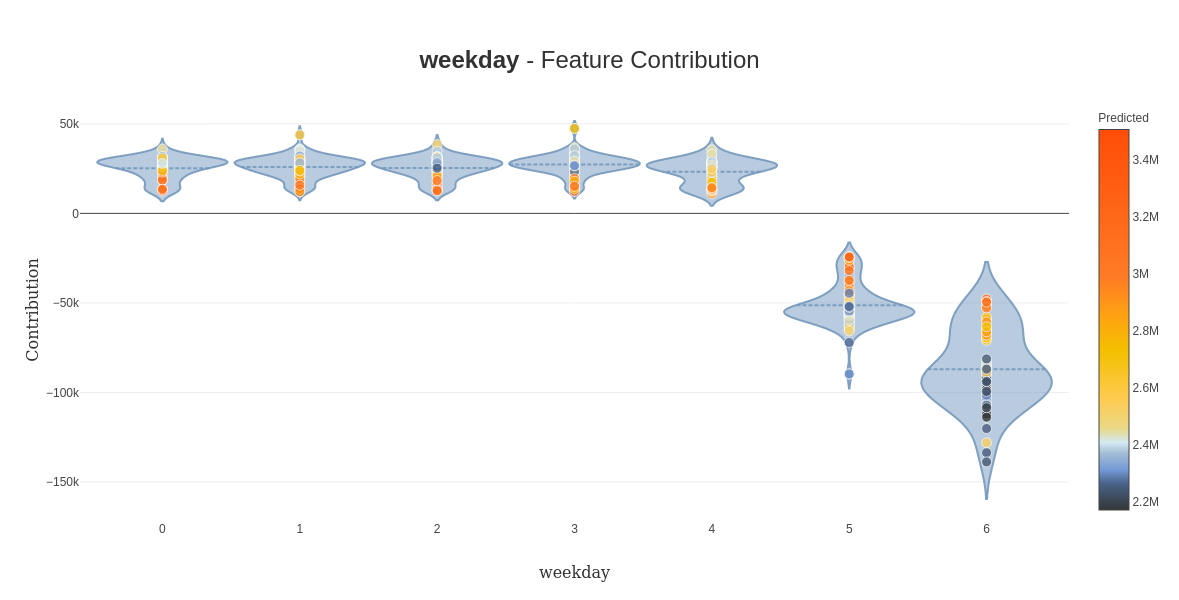

In [32]:
xpl.plot.contribution_plot("weekday")

In [33]:
xpl.filter(max_contrib=8,threshold=100)

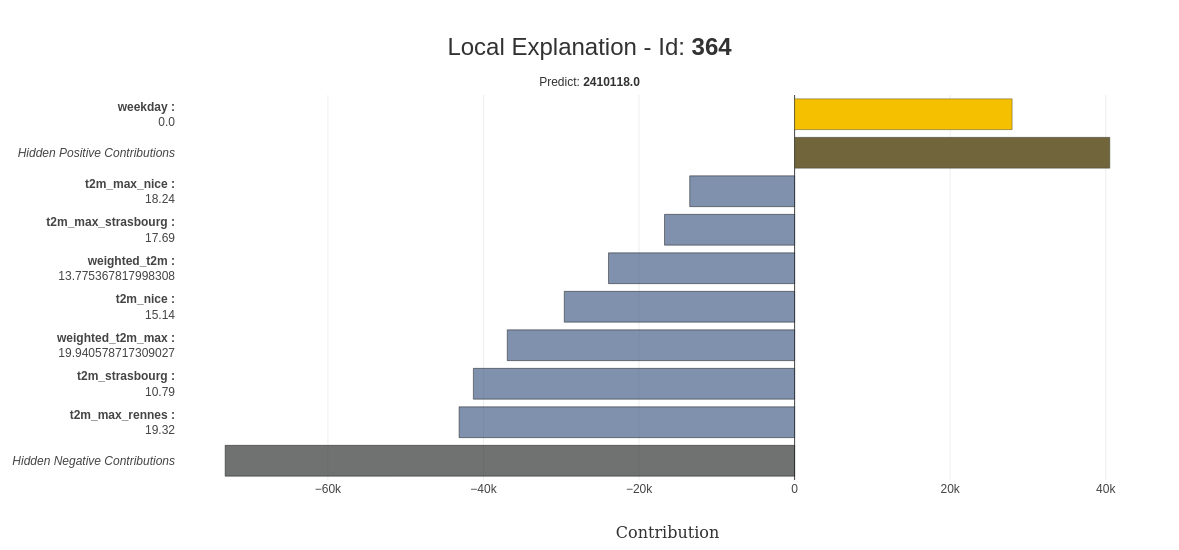

In [34]:
xpl.plot.local_plot(index=364)

In [ ]:
app = xpl.run_app(title_story='Electricity consumption forecast')

In [62]:
app.kill()

In [36]:
predictor = xpl.to_smartpredictor()

In [37]:
predictor.add_input(x=X_2020, ypred=pd.DataFrame(model.predict(X_2020),columns=['pred'],index=X_2020.index))

In [38]:
detailed_contributions = predictor.detail_contributions()
predictor.modify_mask(max_contrib=3)

In [40]:
explanation = predictor.summarize()
explanation.head(7)

,pred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
0,2.974016e+06,t2m_max_strasbourg,3.63,79526.438111,t2m_strasbourg,-0.27,70769.171943,t2m_max_rennes,9.96,58648.515622
1,2.897108e+06,t2m_max_strasbourg,2.72,84424.432622,t2m_strasbourg,-0.55,60281.262977,week_number,1.0,-58904.875076
2,2.809160e+06,week_number,1.0,-47491.74042,t2m_max_strasbourg,4.59,46944.853991,weighted_t2m_max,10.534937,41724.440286
3,2.882707e+06,t2m_max_strasbourg,3.45,90483.397749,t2m_strasbourg,1.6,83545.11575,week_number,1.0,-58135.156642
4,2.723748e+06,week_number,1.0,-73818.543716,weekday,6.0,-66440.959019,t2m_strasbourg,2.11,56394.439521
5,2.991965e+06,t2m_max_strasbourg,4.04,78272.818316,t2m_strasbourg,0.05,75966.496174,week_number,2.0,-58648.55057
6,2.833699e+06,week_number,2.0,-65918.145939,t2m_max_strasbourg,5.11,44454.932458,t2m_max_rennes,13.35,44178.211495
